In [1]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm import tqdm, trange

In [2]:
# seed value for the notebook
np.random.seed(42)

In [3]:
# read data from labelling notebook
#  'tspattern_data_label.ipynb'
df = pd.read_csv('./resources/eurusd_hour_real_labelled.csv', index_col=0,parse_dates=True)
df

,open,high,low,close,upper_shadow,lower_shadow,real_body,slope,indicator
date,,,,,,,,,
2012-03-28 02:00:00,1.33221,1.33319,1.33204,1.33304,0.00015,0.00017,0.00083,neutral,neutral
2012-03-28 03:00:00,1.33301,1.33304,1.33256,1.33287,-0.00003,-0.00031,-0.00014,neutral,neutral
2012-03-28 04:00:00,1.33290,1.33338,1.33255,1.33255,-0.00048,0.00000,-0.00035,neutral,neutral
2012-03-28 05:00:00,1.33257,1.33348,1.33255,1.33322,0.00026,0.00002,0.00065,neutral,neutral
2012-03-28 06:00:00,1.33325,1.33353,1.33154,1.33250,-0.00028,-0.00096,-0.00075,neutral,neutral
...,...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.08620,1.08851,1.08611,1.08713,0.00138,0.00009,0.00093,neutral,neutral
2020-04-29 19:00:00,1.08711,1.08823,1.08659,1.08748,0.00075,0.00052,0.00037,positive,neutral
2020-04-29 20:00:00,1.08747,1.08788,1.08691,1.08708,-0.00041,-0.00017,-0.00039,positive,neutral


In [4]:
# create the feature (X) and category (y) data sets
X = df.drop(['slope', 'indicator'], axis=1)
y = df['slope']
print(X.shape, y.shape)

(50000, 7) (50000,)


In [5]:
# split 75/25 (train/test)
#  for timeseries keep data in continuous form (not random)
# calculate the number of train data points
train_pct_index = int(0.75 * len(X))

# slice the data frames
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# summarise the results
print(f'| X_train: {X_train.shape} | y_train: {y_train.shape} |\n'
      f'| X_test:  {X_test.shape} | y_test:  {y_test.shape} |')

| X_train: (37500, 7) | y_train: (37500,) |
| X_test:  (12500, 7) | y_test:  (12500,) |


In [6]:
# target category encoding
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# encoding
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# categories
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# summarise the results
print(f'| y_train: {y_train_categorical.shape} | y_test: {y_test_categorical.shape} |')

# confirm the categories
print(f'| classes: {list(label_encoder.classes_)} |')

| y_train: (37500, 3) | y_test: (12500, 3) |
| classes: ['negative', 'neutral', 'positive'] |


In [7]:
# gramian angular matrices (gam):
#  https://jfin-swufe.springeropen.com/articles/10.1186/s40854-020-00187-0
#  https://www.aaai.org/ocs/index.php/WS/AAAIW15/paper/viewFile/10179/10251 
#  https://github.com/pecu/Series2GAF/blob/master/cnn_example/series2gaf.py

# datasets and features
dataset_list = ['train', 'test']
feature_list = ['close', 'real_body']

# image size => window_size(rows) x window_size(cols)
window_size = 10

# loop through each dataset
for this_dataset in dataset_list:
    
    # intialise the gam field for the dataset
    gramian_field = []
    
    # number of data points
    if this_dataset == 'train':
        n = len(X_train['close'])
    if this_dataset == 'test':
        n = len(X_test['close'])
    
    # loop through each feature
    for this_feature in feature_list:

        # initialise the gam field for the feture
        gam_feature_set = []

        # loop through the data
        for i_data in trange(window_size, n+1, desc="Generating...", ascii=True):

            # select the data points to convert frm timeseries to gam (image)
            if this_dataset == 'train':
                full_window_data =  list(X_train[this_feature][i_data-window_size : i_data])
            if this_dataset == 'test':
                full_window_data =  list(X_test[this_feature][i_data-window_size : i_data])

            # scale the data
            rescaled_ts = np.zeros((window_size, window_size), float)
            min_ts = np.min(full_window_data)
            max_ts = np.max(full_window_data)
            diff = max_ts - min_ts
            if diff != 0:
                rescaled_ts = (full_window_data - min_ts) / diff

            # initialise the image
            this_gam = np.zeros((window_size, window_size), float)

            # calculate a component of the gam
            sin_ts = np.sqrt(np.clip(1 - rescaled_ts**2, 0, 1))

            # calculate the gam - summation method
            this_gam = np.outer(rescaled_ts, rescaled_ts) - np.outer(sin_ts, sin_ts)

            # add the gam to the feature set
            gam_feature_set.append(this_gam)

            # clear the gam ready for next
            del this_gam

        # ass the gam field of the feature set to the dataset
        gramian_field.append(gam_feature_set)

        # clear the gam field of the feature set
        del gam_feature_set
  
    # finalise the gam field for each dataset
    if this_dataset == 'train':
        gam_train = np.array(gramian_field)
        gam_train = np.moveaxis(gam_train, 0, 3)
    if this_dataset == 'test':
        gam_test = np.array(gramian_field)
        gam_test = np.moveaxis(gam_test, 0, 3)
    
# summarise the results
print(f'| gam_train: {gam_train.shape} | gam_test: {gam_test.shape} |')

Generating...: 100%|##########| 12491/12491 [00:01<00:00, 6439.22it/s]

| gam_train: (37491, 10, 10, 2) | gam_test: (12491, 10, 10, 2) |


In [8]:
y_train_labels = label_encoder.inverse_transform(y_train_encoded)
(unique_train, counts_train) = np.unique(y_train_labels, return_counts=True)
np.asarray((unique_train, counts_train)).T

array([['negative', 6760],
       ['neutral', 23960],
       ['positive', 6780]], dtype=object)

In [9]:
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
(unique_test, counts_test) = np.unique(y_test_labels, return_counts=True)
np.asarray((unique_test, counts_test)).T

array([['negative', 2326],
       ['neutral', 7877],
       ['positive', 2297]], dtype=object)

In [10]:
# balancing the training dataset by
# randomised under-sampling gam fields of the majority class (neutral)
# for categorical clasification where 'neutral' is majority

# randome seed for the cell
np.random.seed(42)

# indices of gams that correspond to 'neutral' category
minority_indices = np.where(y_train_labels[window_size-1:] != 'neutral')
majority_indices = np.where(y_train_labels[window_size-1:] == 'neutral')

# choose randomly which 'neutral' categofry gams to keep
undersample_indexes = np.random.choice(majority_indices[0], size=np.max(np.sort(counts_train)[:-1]), replace=False)

# indices of gams remaining 
keep_indices = np.sort(np.concatenate((undersample_indexes, minority_indices[0])))

# reconstruct the data sets
gam_train_undersampled = gam_train[keep_indices]
gam_test_undersampled = gam_test
y_train_categorical_undersampled = y_train_categorical[window_size-1:][keep_indices]
y_train_encoded_undersampled = y_train_encoded[window_size-1:][keep_indices]
y_test_categorical_undersampled = y_test_categorical[window_size-1:]
y_test_encoded_undersampled = y_test_encoded[window_size-1:]


# # for binary classification - classification performed on 'positive' & 'negative'
# #  find indices where calss is 'neutral' and remove from data and categories
# keep_indices = np.where(y_train_labels[window_size:] != 'neutral')
# keep_indices = np.where(y_test_labels[window_size:] != 'neutral')
# gam_train_undersampled = gam_train[keep_indices]
# gam_test_undersampled = gam_test[keep_indices]
# y_train_categorical_undersampled = y_train_categorical[window_size:][keep_indices]
# y_test_categorical_undersampled = y_test_categorical[window_size:][keep_indices]
# y_train_encoded_undersampled = y_train_encoded[window_size:][keep_indices]
# y_test_encoded_undersampled = y_test_encoded[window_size:][keep_indices]

In [11]:
# confirm the train dataset is 'balanced'
y_train_labels = label_encoder.inverse_transform(y_train_encoded_undersampled)
(unique, counts) = np.unique(y_train_labels, return_counts=True)
np.asarray((unique, counts)).T

array([['negative', 6760],
       ['neutral', 6780],
       ['positive', 6780]], dtype=object)

In [12]:
# review the test dataset category counts
y_test_labels = label_encoder.inverse_transform(y_test_encoded_undersampled)
(unique, counts) = np.unique(y_test_labels, return_counts=True)
np.asarray((unique, counts)).T

array([['negative', 2323],
       ['neutral', 7871],
       ['positive', 2297]], dtype=object)

In [13]:
# model architecture

# model type
model = Sequential()

# image shape and numbe rof channels
model.add(Input(shape=(window_size, window_size, 2)))  # gam images

# first convolutional layer
model.add(Conv2D(16, 3, activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second convolutional layer
model.add(Conv2D(32, 3, activation='relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# fully connected layers
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

# output layer
model.add(Dense(len(unique_train), activation='softmax'))  # classification layer.
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 16)          304       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [14]:
# compile the model
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

# categorical classification
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# binary classification
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [15]:
# train the model
history = model.fit(
    x=gam_train_undersampled, 
    y=y_train_categorical_undersampled, 
    epochs=300, 
    batch_size=64,
    validation_split=0.25, 
    verbose=2,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)]
)

Train on 15240 samples, validate on 5080 samples
Epoch 1/300
15240/15240 - 3s - loss: 1.0420 - accuracy: 0.4721 - val_loss: 0.8981 - val_accuracy: 0.6709
Epoch 2/300
15240/15240 - 2s - loss: 0.8065 - accuracy: 0.6387 - val_loss: 0.6283 - val_accuracy: 0.7142
Epoch 3/300
15240/15240 - 2s - loss: 0.6618 - accuracy: 0.7032 - val_loss: 0.5198 - val_accuracy: 0.7675
Epoch 4/300
15240/15240 - 2s - loss: 0.5755 - accuracy: 0.7504 - val_loss: 0.4463 - val_accuracy: 0.8150
Epoch 5/300
15240/15240 - 2s - loss: 0.5213 - accuracy: 0.7762 - val_loss: 0.4025 - val_accuracy: 0.8335
Epoch 6/300
15240/15240 - 2s - loss: 0.4790 - accuracy: 0.7988 - val_loss: 0.3671 - val_accuracy: 0.8486
Epoch 7/300
15240/15240 - 2s - loss: 0.4529 - accuracy: 0.8111 - val_loss: 0.3455 - val_accuracy: 0.8553
Epoch 8/300
15240/15240 - 2s - loss: 0.4266 - accuracy: 0.8260 - val_loss: 0.3238 - val_accuracy: 0.8638
Epoch 9/300
15240/15240 - 2s - loss: 0.4089 - accuracy: 0.8325 - val_loss: 0.3101 - val_accuracy: 0.8705
Epoch 

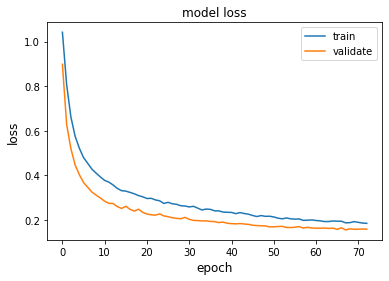

In [16]:
# review the model convergence - 'loss'
metric1 = 'loss'
plt.figure()
plt.plot(history.history[metric1])
plt.plot(history.history['val_' + metric1])
plt.title('model ' + metric1)
plt.ylabel(metric1, fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.legend(['train', 'validate'], loc='best')
plt.show()
plt.close()

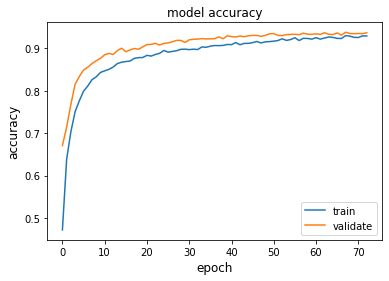

In [17]:
# review the model convergence - 'accuracy'
metric2 = 'accuracy'
plt.figure()
plt.plot(history.history[metric2])
plt.plot(history.history['val_' + metric2])
plt.title('model ' + metric2)
plt.ylabel(metric2, fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.legend(['train', 'validate'], loc='best')
plt.show()
plt.close()

In [18]:
# evaluate the trained model with the test data
test_loss, test_acc = model.evaluate(gam_test_undersampled, y_test_categorical_undersampled, verbose=0)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

Test accuracy 0.90489155
Test loss 0.2227269381910417


In [19]:
# review the classification report
y_pred = model.predict(gam_test_undersampled).argmax(axis=1)
y_true = y_test_categorical_undersampled.argmax(axis=1)
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_)) 

              precision    recall  f1-score   support

    negative       0.79      0.98      0.88      2323
     neutral       0.98      0.86      0.92      7871
    positive       0.82      0.97      0.89      2297

    accuracy                           0.90     12491
   macro avg       0.87      0.94      0.90     12491
weighted avg       0.92      0.90      0.91     12491



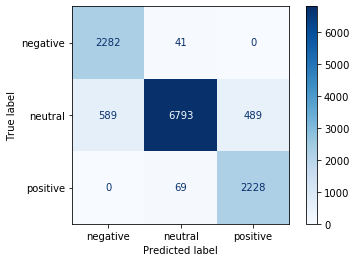

In [20]:
# review confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues');

In [21]:
# save the model
model.save('./analysis/eurusd_hour_real_model.h5')